In [1]:
%matplotlib notebook

from sdss import SDSS
import mikkel_tools.utility as mt_util
import plot as sds_plt

import numpy as np
#import cupy as cp
import scipy as sp
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

import pyshtools
import pickle

comment = "Finding sparsity by digging into histogram reproduction"
nb_name = "nb_seqsim_find_sparsity_condtab_digging"

# Core

In [2]:
core = SDSS(comment, N_SH = 30, sim_type = "core", sat_height = 350)

core.grid_glq(nmax = 30, r_at = core.r_cmb)

grid_in = np.array([core.grid_glq_phi, 90-core.grid_glq_theta]).T
core.make_grid(core.r_cmb, grid_in, calc_sph_d = True)


In [3]:
core.generate_map()

In [4]:
#core.data = core.data - np.mean(core.data)

<IPython.core.display.Javascript object>


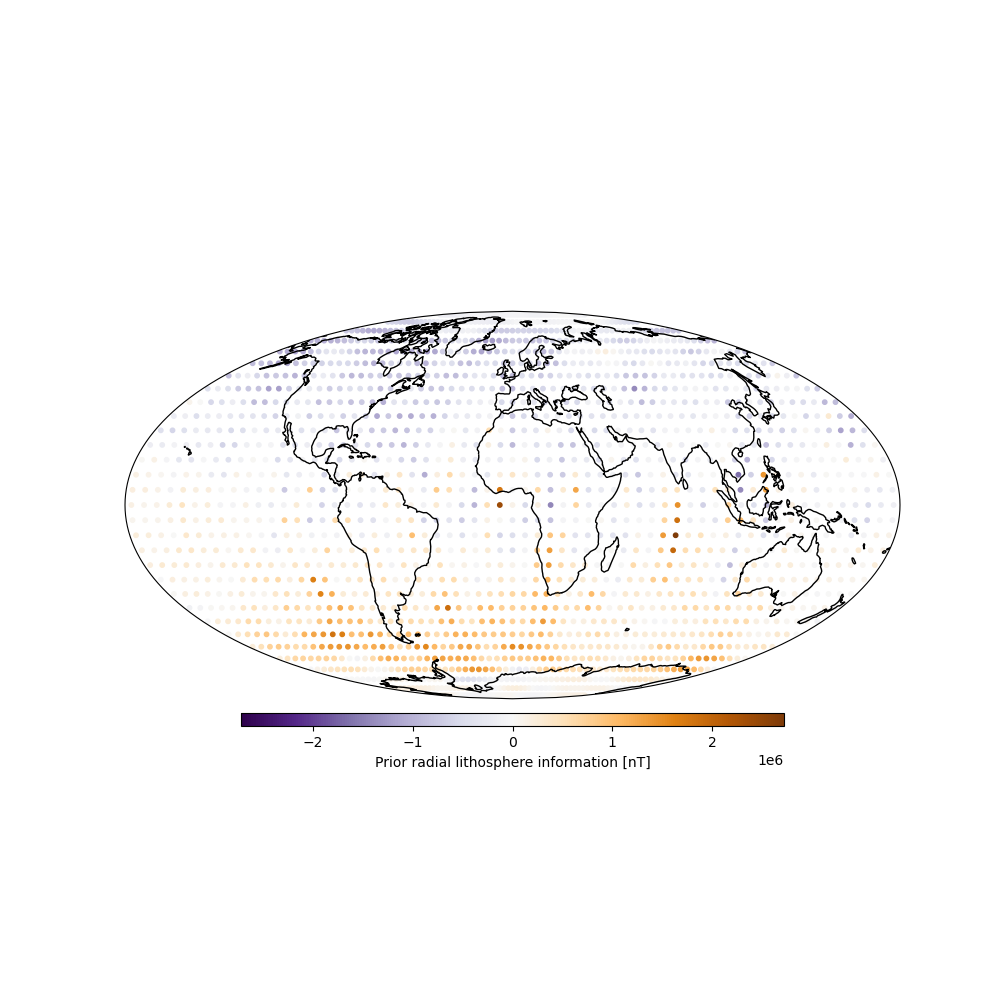

In [5]:
mt_util.plot_cartopy_global(lat = core.lat, lon = core.lon, plot_quality = "high", 
                            data=core.data, point_size=10, shift_grid = True, 
                            transpose_grid = True, shape = (121,61), cmap = 'PuOr_r', 
                            title="Prior radial lithosphere information")

In [6]:
core.condtab(normsize=10*len(core.data), quantiles = len(core.data), 
             rangn_lim = 3.5, rangn_N = 21, rangv_lim = 0.5, rangv_N = 21)

____semi-variogram setup___

Number of data used: 3575881
Max data distance: 10919.075 km
Lag length chosen: 200.0 km
Number of lags: 54
Number of modelling lags: 20

Semi-variogram model determined, starting LUT computation



<IPython.core.display.Javascript object>


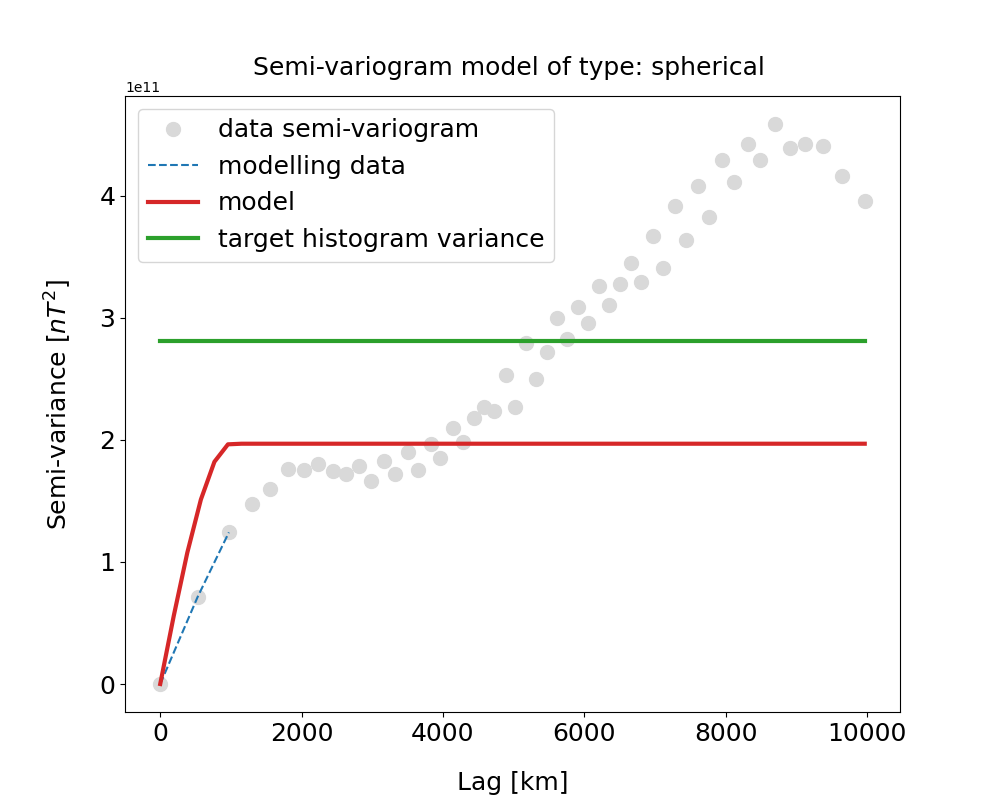

In [52]:
#core.semivar(model_lags = "all", model = "exponential", max_dist = 20000, lag_length = 200,
#             zero_nugget = True, hit_target_var = True)

#keep_sv_curve = core.sv_curve.copy()
#keep_lags_sv_curve = core.lags_sv_curve.copy()

C_e_const = 2.0

nugget = C_e_const**2
nugget_p = 0.01
var_fac = 0.70

#set_model = {"a": 2000, "C0": var_fac*core.target_var*nugget_p, "C1": var_fac*core.target_var*(1-nugget_p), "C2": None, "C3": None}
set_model = {"a": 1000, "C0": nugget, "C1": var_fac*core.target_var-nugget, "C2": None, "C3": None}


core.semivar(model_lags = 20, model = "spherical", max_dist = 20000, lag_length = 200,
             zero_nugget = True, hit_target_var = True, set_model = set_model)

#core.semivar(model_lags = 3, model = "exponential", max_dist = 20000, lag_length = 200,
#             zero_nugget = True, hit_target_var = True)


#%% PLOT SEMI-VARIOGRAM
plt.figure(figsize=(10,8)) 
plt.plot(core.lags,core.pics,'o', markersize=10,color = '0.85',label='data semi-variogram')
plt.plot(core.lags_model,core.pics_model,'--',markersize=10,label='modelling data')
plt.plot(core.lags_sv_curve,core.sv_curve,color='C3', linewidth = 3,label='model')
#plt.plot(keep_lags_sv_curve,keep_sv_curve,"--",color='C1',linewidth = 3,label='model large lag')

plt.plot(core.lags_sv_curve,np.ones(core.lags_sv_curve.shape)*core.target_var,linewidth = 3, color="C2", label="target histogram variance")
plt.ylabel('Semi-variance $[%s^2]$' % "nT",fontsize=18,labelpad=18)
plt.xlabel('Lag [km]',fontsize=18,labelpad=18)
plt.title("Semi-variogram model of type: %s " % core.model_names[core.model],fontsize=18,y=1.02)
plt.legend(loc='best',fontsize=18)
ax = plt.gca()
ax.tick_params(axis = 'both', which = 'major', labelsize = 18)
plt.show()

In [43]:
print(core)


______current attributes______

a:                     6371.2
r_sat:                 6721.2
r_cmb:                 3480.0
rad:                   0.017453292519943295
mu0:                   1.2566370614359173e-06
comment:               Finding sparsity by digging into histogram reproduction
class_abs_path:        /home/mikotz/spherical_direct_sequential_simulation
N_SH:                  30
N_SH_secondary:        None
sim_type:              core
grid_glq_zero:         (31,), Max/Min: 1.00 / -1.00
grid_glq_w_shtools:    (31,), Max/Min: 0.10 / 0.01
grid_glq_shape:        (2,), Max/Min: 61.00 / 31.00
grid_glq_w:            (1891,), Max/Min: 0.10 / 0.01
grid_glq_radial:       (1891,), Max/Min: 3480.00 / 3480.00
grid_glq_theta:        (1891,), Max/Min: 175.63 / 4.37
grid_glq_phi:          (1891,), Max/Min: 354.10 / 0.00
grid_glq_N:            1891
grid_glq_nmax:         30
r_grid:                3480.0
grid:                  (1891, 2)
sph_d:                 (1891, 1891)
lon:                 

# Synthetic sat

In [25]:
s_sat = SDSS(comment, N_SH = 30, sim_type = "core", sat_height = 350, N_SH_secondary = None)

s_sat.load_swarm("A")

grid_in = np.array([s_sat.swarm_phi, 90-s_sat.swarm_theta]).T
s_sat.make_grid(s_sat.swarm_radius, grid_in, calc_sph_d = False)

#s_sat.grid_equal_area(N_grid= 500, r_at = s_sat.r_sat, poles_remove = True)
#grid_in = np.array([s_sat.grid_eqa_phi, 90-s_sat.grid_eqa_theta]).T
#s_sat.grid(s_sat.r_sat, grid_in, calc_sph_d = False)

In [26]:
s_sat.generate_map(grid_type = "swarm")

In [27]:
s_sat.data += np.random.normal(scale = C_e_const, size = s_sat.data.shape)

In [28]:
mt_util.plot_cartopy_global(lat = s_sat.lat, lon = s_sat.lon, plot_quality = "high", point_size=5, 
                            data=s_sat.data, cmap = 'PuOr_r', title="Synthetic satellite data")

<IPython.core.display.Javascript object>

In [29]:
print(s_sat)


______current attributes______

a:                6371.2
r_sat:            6721.2
r_cmb:            3480.0
rad:              0.017453292519943295
mu0:              1.2566370614359173e-06
comment:          Finding sparsity by digging into histogram reproduction
class_abs_path:   /home/mikotz/spherical_direct_sequential_simulation
N_SH:             30
N_SH_secondary:   None
sim_type:         core
swarm_theta:      (2773,), Max/Min: 177.35 / 22.39
swarm_phi:        (2773,), Max/Min: 179.68 / -179.59
swarm_radius:     (2773,), Max/Min: 6825.19 / 6806.85
swarm_obs:        (2773,), Max/Min: 53117.43 / -48881.72
swarm_N:          2773
r_grid:           (2773,), Max/Min: 6825.19 / 6806.85
grid:             (2773, 2)
sph_d:            None
lon:              (2773,), Max/Min: 179.68 / -179.59
lat:              (2773,), Max/Min: 67.61 / -87.35
N_grid:           2773
B_ensemble_swarm: (2773, 3)
data:             (2773,), Max/Min: 85909.06 / -84353.32
target_var:       2650032519.9717584
target_me


Gauss-Legendre RMSE:	 1.966794920099


<IPython.core.display.Javascript object>


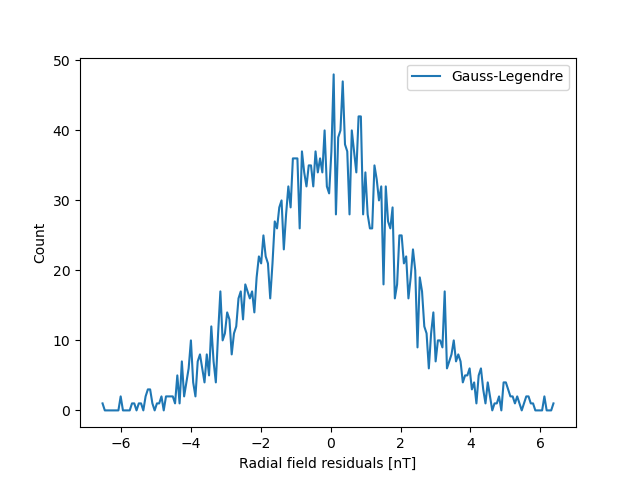

In [55]:
core.integrating_kernel(s_sat, C_e_const = C_e_const)

 |OOOOOOOOOO| 100.0%   realization nr. 0. Counter: 1891/1891, Running error magnitude: 5.2
Run time: 10.444 minutes 
Total elapsed time: 10.444 minutes 
Variance: 290769884470.830
Mean: -6855.246
Max: 2323695.504
Min: -1637703.202
Run nr.: 1


Seqsim RMSE:	 [[1.953517]]


<IPython.core.display.Javascript object>


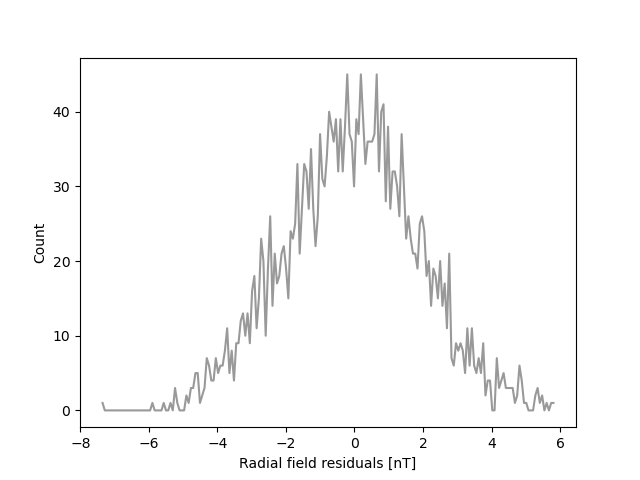

In [56]:
N_sim = 1

core.run_sim(N_sim, core.grid_glq_N, core.C_mm_all, core.C_dd, core.C_dm_all, core.G,
        s_sat.data, core.data, scale_m_i = True, unit_d = False, collect_all = True,
        sense_running_error = True, save_string = nb_name)

In [57]:
core.realization_to_sh_coeff(core.r_cmb)

In [58]:
core.covmod_lsq_equiv(s_sat.data, core.C_mm_all, core.G, core.r_cmb)

<IPython.core.display.Javascript object>


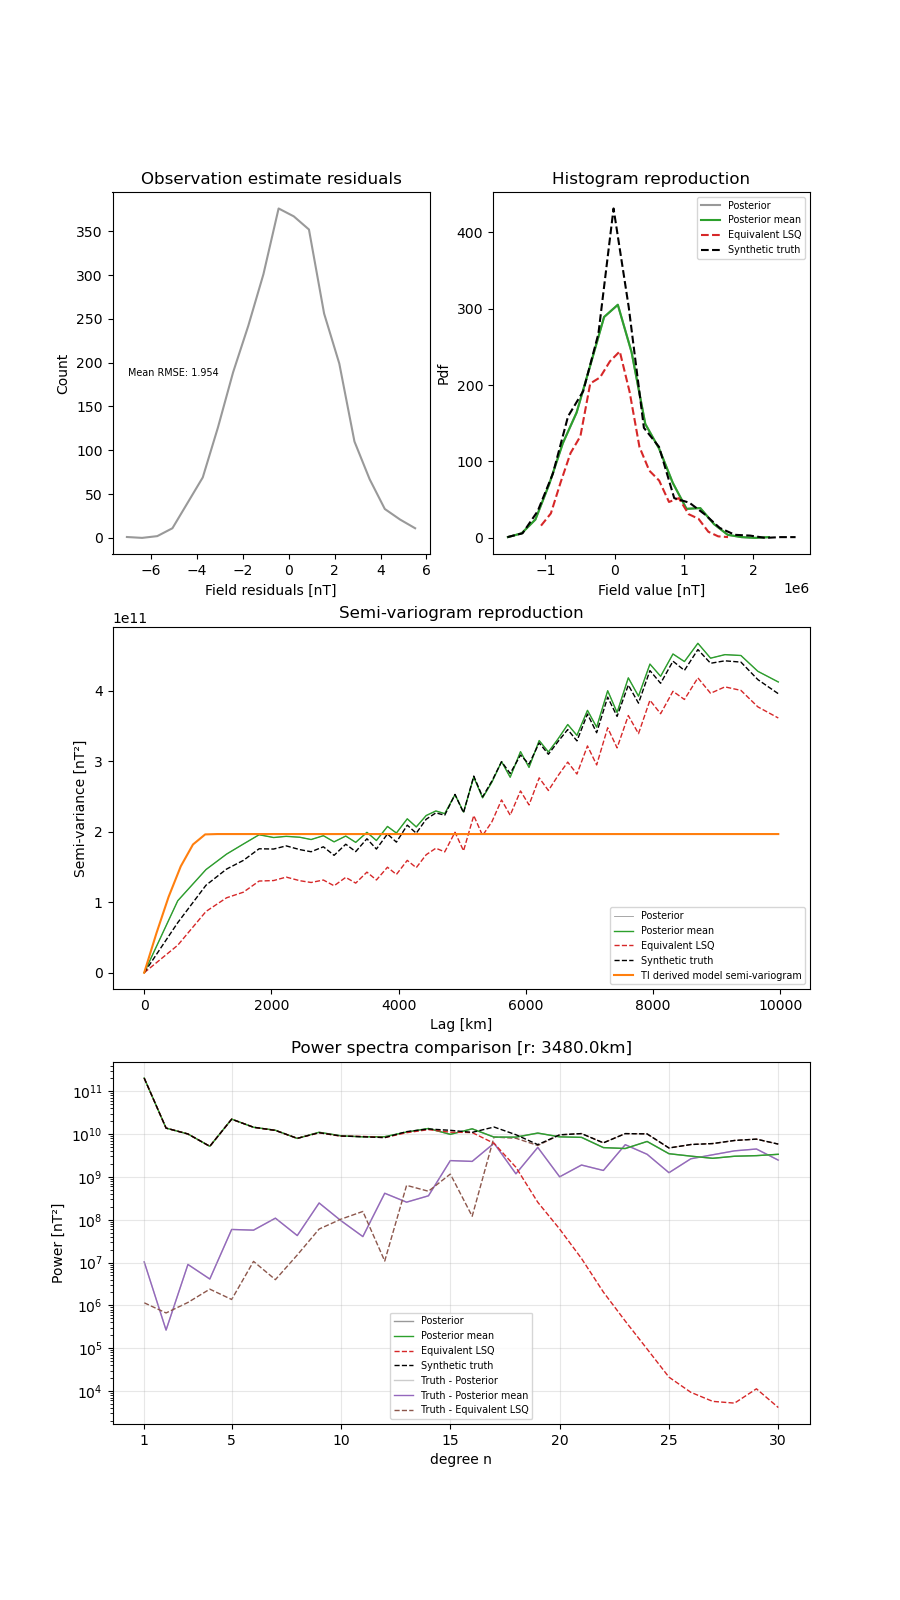

In [59]:
# Reload plot module when making small changes
import importlib
importlib.reload(mt_util)

core.grid_glq(nmax = 30, r_at = core.r_cmb)
mt_util.plot_sdssim_reproduce(core, core.m_DSS_res, m_equiv_lsq = core.m_equiv_lsq,
                              lags_use = 1000, spec_r_at = core.r_cmb,
                              model_dict = {}, figsize=(9,16),
                              hist_bins = 20, res_bins = 20,
                              savefig = False, save_string = "core_A_sh30_pdfhist", save_dpi = 100)

# Conditional table investigation

In [47]:
print(core)


______current attributes______

a:                     6371.2
r_sat:                 6721.2
r_cmb:                 3480.0
rad:                   0.017453292519943295
mu0:                   1.2566370614359173e-06
comment:               Finding sparsity by digging into histogram reproduction
class_abs_path:        /home/mikotz/spherical_direct_sequential_simulation
N_SH:                  30
N_SH_secondary:        None
sim_type:              core
grid_glq_zero:         (31,), Max/Min: 1.00 / -1.00
grid_glq_w_shtools:    (31,), Max/Min: 0.10 / 0.01
grid_glq_shape:        (2,), Max/Min: 61.00 / 31.00
grid_glq_w:            (1891,), Max/Min: 0.10 / 0.01
grid_glq_radial:       (1891,), Max/Min: 3480.00 / 3480.00
grid_glq_theta:        (1891,), Max/Min: 175.63 / 4.37
grid_glq_phi:          (1891,), Max/Min: 354.10 / 0.00
grid_glq_N:            1891
grid_glq_nmax:         30
r_grid:                3480.0
grid:                  (1891, 2)
sph_d:                 (1891, 1891)
lon:                 

# FIT SV small cond table, histogram centered, no unit dm,dv

<IPython.core.display.Javascript object>


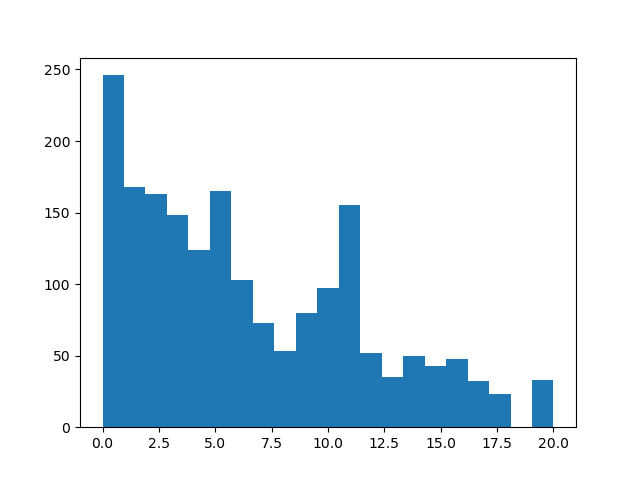

<IPython.core.display.Javascript object>


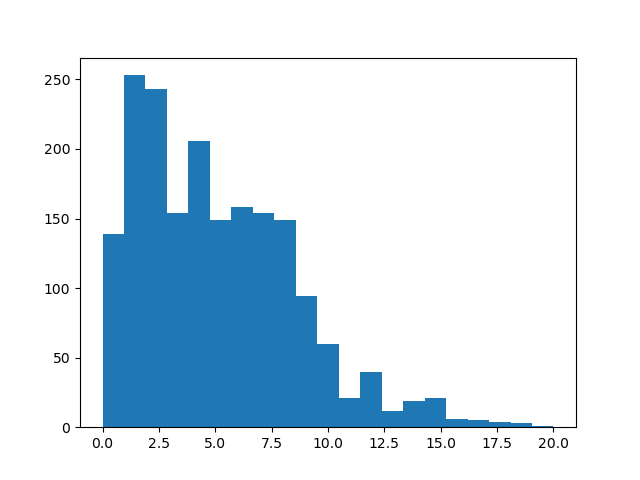

In [81]:
idx_n_hist =[]
idx_v_hist = []

for idx_n, idx_v in core.idx_nv_collect:
    idx_n_hist.append(idx_n)
    idx_v_hist.append(idx_v)


plt.figure()
plt.hist(idx_n_hist,bins=21)
plt.show()

plt.figure()
plt.hist(idx_v_hist,bins=21)
plt.show()

# FIT SV small cond table, histogram centered

<IPython.core.display.Javascript object>


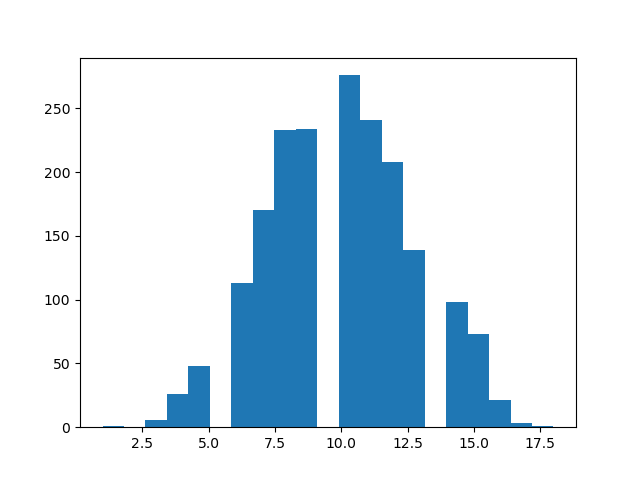

<IPython.core.display.Javascript object>


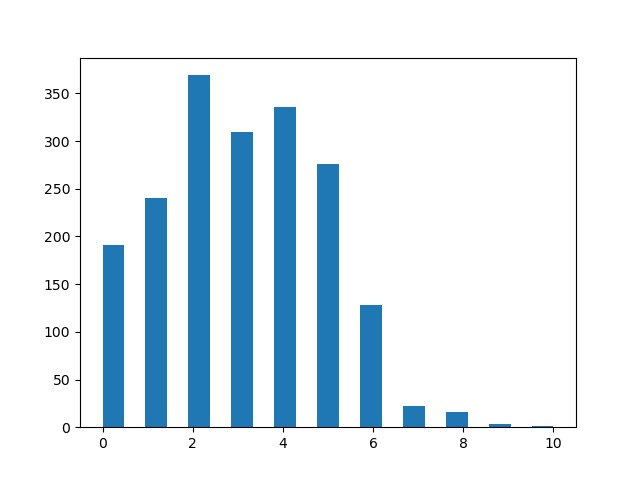

In [51]:
idx_n_hist =[]
idx_v_hist = []

for idx_n, idx_v in core.idx_nv_collect:
    idx_n_hist.append(idx_n)
    idx_v_hist.append(idx_v)


plt.figure()
plt.hist(idx_n_hist,bins=21)
plt.show()

plt.figure()
plt.hist(idx_v_hist,bins=21)
plt.show()

# FIT SV small cond table

<IPython.core.display.Javascript object>


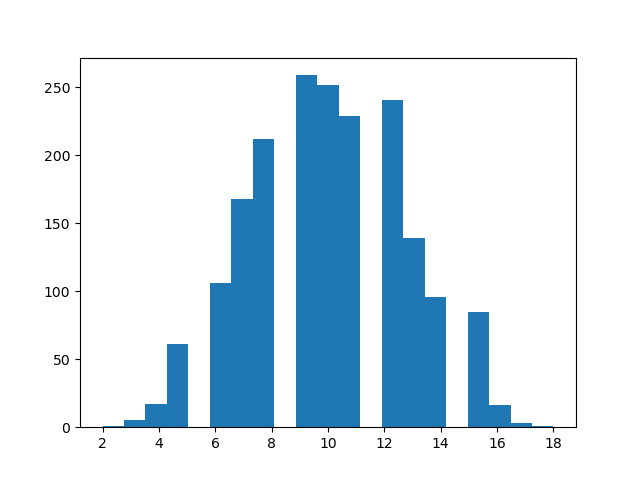

<IPython.core.display.Javascript object>


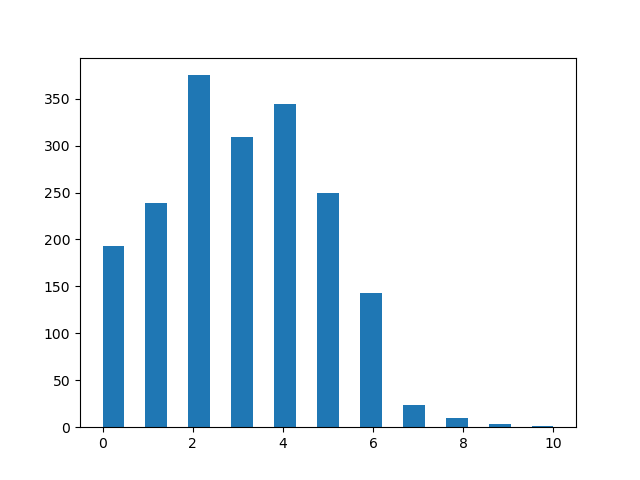

In [35]:
idx_n_hist =[]
idx_v_hist = []

for idx_n, idx_v in core.idx_nv_collect:
    idx_n_hist.append(idx_n)
    idx_v_hist.append(idx_v)


plt.figure()
plt.hist(idx_n_hist,bins=21)
plt.show()

plt.figure()
plt.hist(idx_v_hist,bins=21)
plt.show()

# FIT SV with small v-range of high resolution

<IPython.core.display.Javascript object>


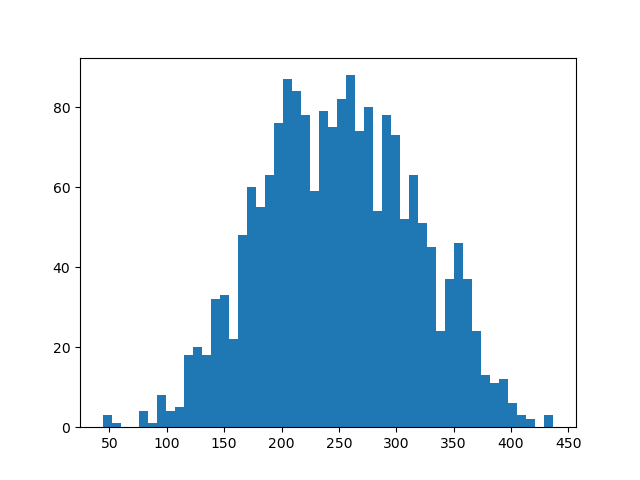

<IPython.core.display.Javascript object>


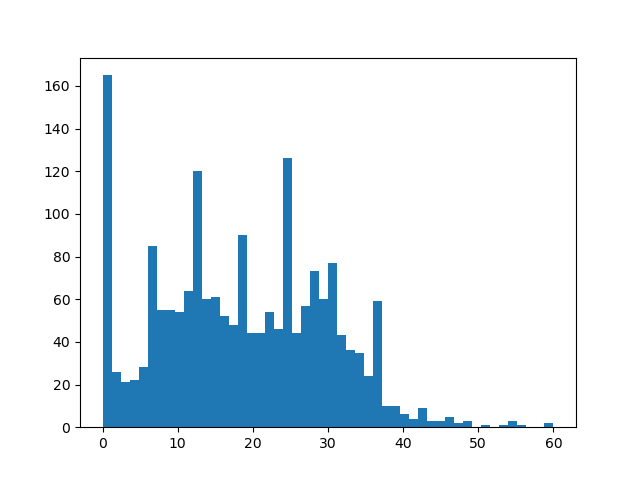

In [32]:
idx_n_hist =[]
idx_v_hist = []

for idx_n, idx_v in core.idx_nv_collect:
    idx_n_hist.append(idx_n)
    idx_v_hist.append(idx_v)


plt.figure()
plt.hist(idx_n_hist,bins=50)
plt.show()

plt.figure()
plt.hist(idx_v_hist,bins=50)
plt.show()

# FIT SV with larger n-range (4.5)

<IPython.core.display.Javascript object>


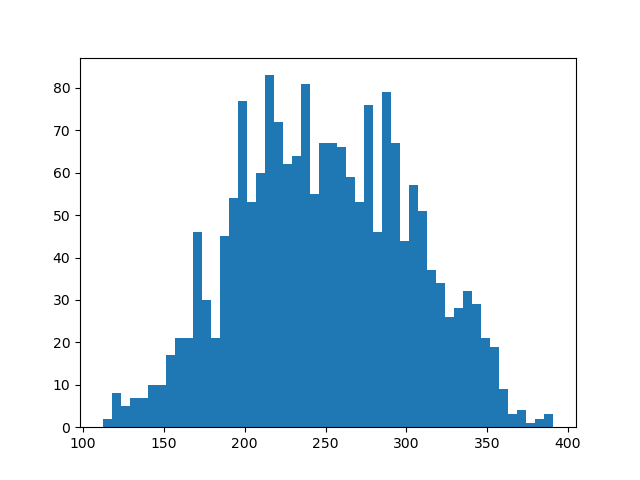

<IPython.core.display.Javascript object>


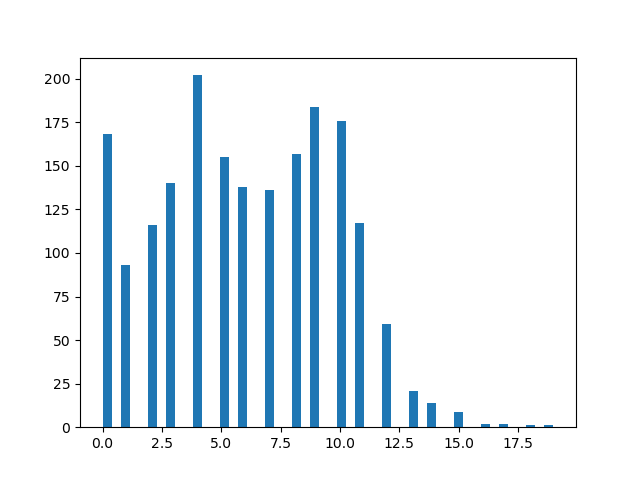

In [18]:
idx_n_hist =[]
idx_v_hist = []

for idx_n, idx_v in core.idx_nv_collect:
    idx_n_hist.append(idx_n)
    idx_v_hist.append(idx_v)


plt.figure()
plt.hist(idx_n_hist,bins=50)
plt.show()

plt.figure()
plt.hist(idx_v_hist,bins=50)
plt.show()

# FIT SV with lower max semi-variance

<IPython.core.display.Javascript object>


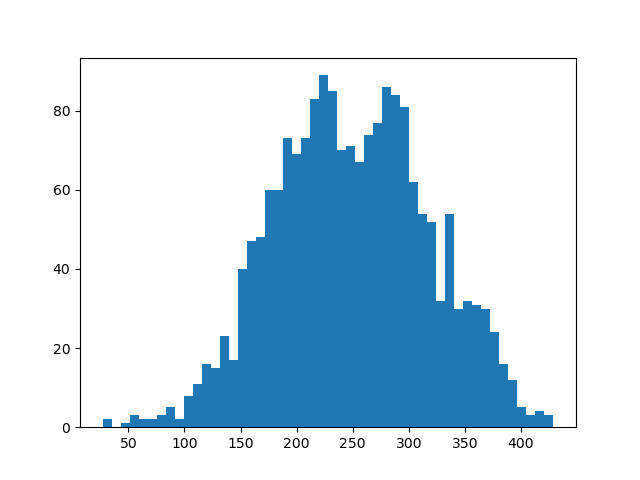

<IPython.core.display.Javascript object>


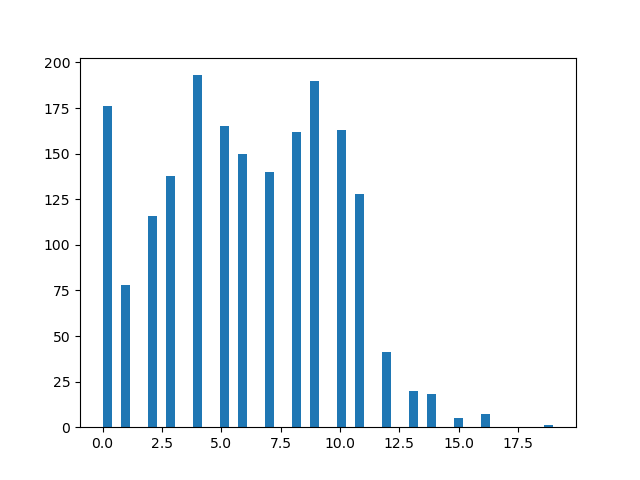

In [20]:
idx_n_hist =[]
idx_v_hist = []

for idx_n, idx_v in core.idx_nv_collect:
    idx_n_hist.append(idx_n)
    idx_v_hist.append(idx_v)


plt.figure()
plt.hist(idx_n_hist,bins=50)
plt.show()

plt.figure()
plt.hist(idx_v_hist,bins=50)
plt.show()

# Fit SV with 1% nugget

<IPython.core.display.Javascript object>


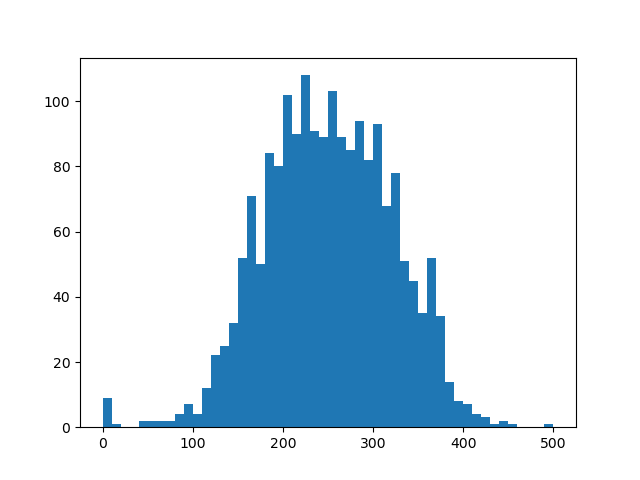

<IPython.core.display.Javascript object>


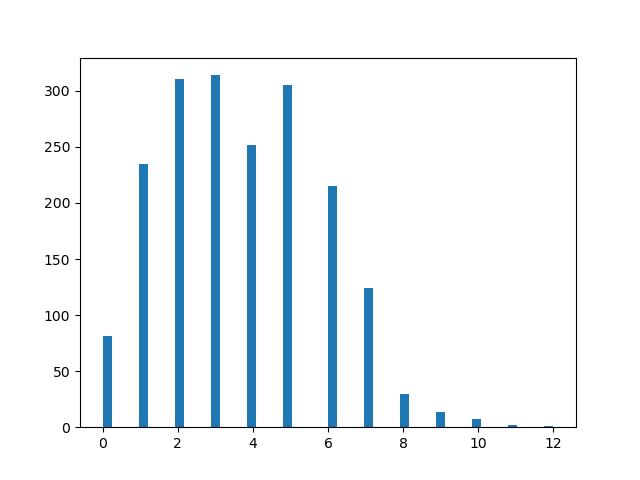

In [42]:
idx_n_hist =[]
idx_v_hist = []

for idx_n, idx_v in core.idx_nv_collect:
    idx_n_hist.append(idx_n)
    idx_v_hist.append(idx_v)


plt.figure()
plt.hist(idx_n_hist,bins=50)
plt.show()

plt.figure()
plt.hist(idx_v_hist,bins=50)
plt.show()

# Fit SV with 20% nugget

<IPython.core.display.Javascript object>


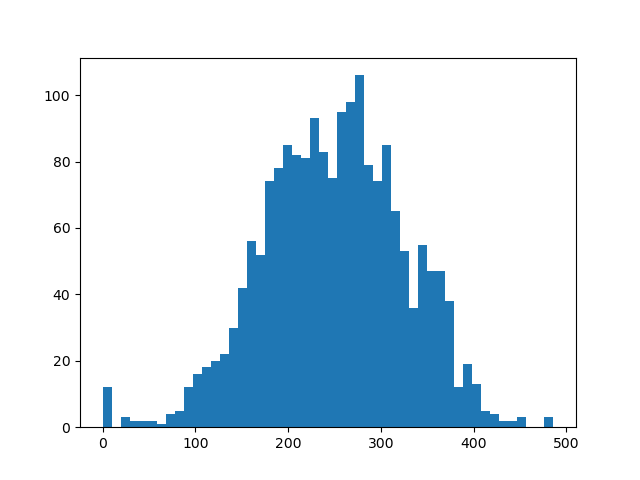

<IPython.core.display.Javascript object>


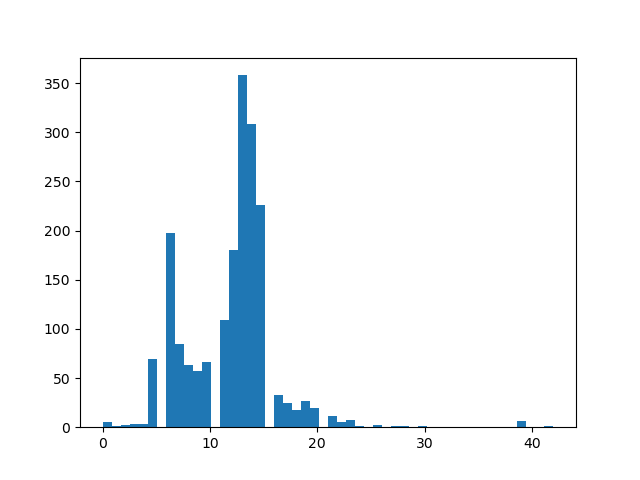

In [21]:
idx_n_hist =[]
idx_v_hist = []

for idx_n, idx_v in core.idx_nv_collect:
    idx_n_hist.append(idx_n)
    idx_v_hist.append(idx_v)


plt.figure()
plt.hist(idx_n_hist,bins=50)
plt.show()

plt.figure()
plt.hist(idx_v_hist,bins=50)
plt.show()

# Long SV (high correlation for longer lags)

<IPython.core.display.Javascript object>


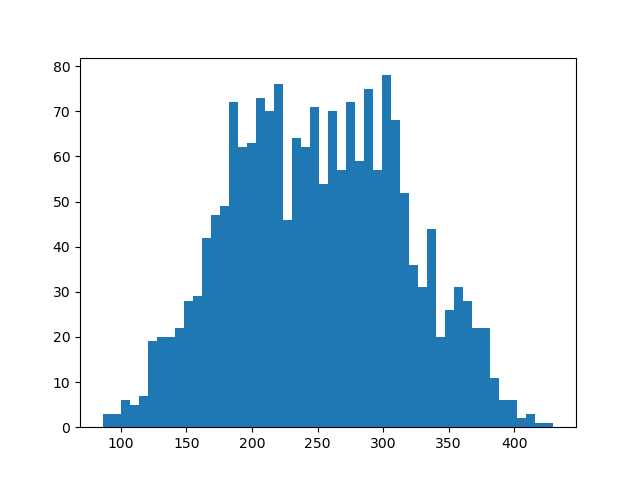

<IPython.core.display.Javascript object>


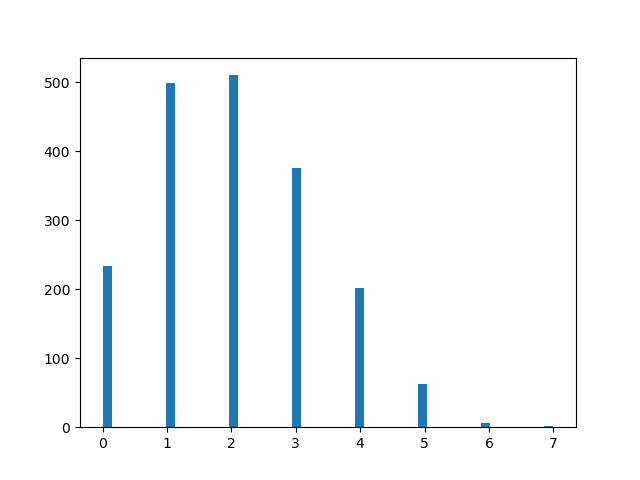

In [46]:
idx_n_hist =[]
idx_v_hist = []

for idx_n, idx_v in core.idx_nv_collect:
    idx_n_hist.append(idx_n)
    idx_v_hist.append(idx_v)


plt.figure()
plt.hist(idx_n_hist,bins=50)
plt.show()

plt.figure()
plt.hist(idx_v_hist,bins=50)
plt.show()

# Sharp SV (low correlation for longer lags)

<IPython.core.display.Javascript object>


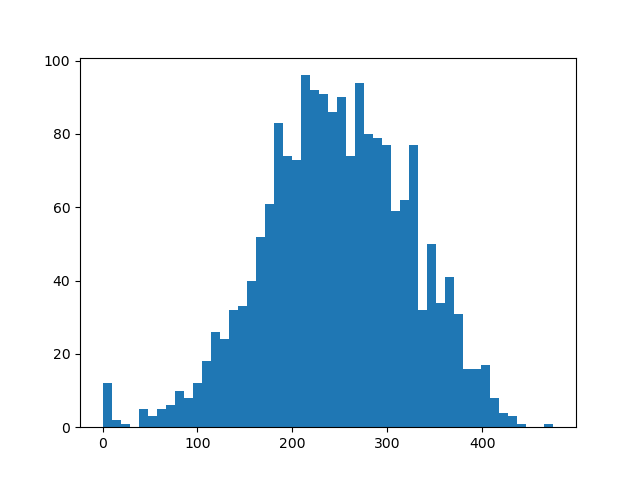

<IPython.core.display.Javascript object>


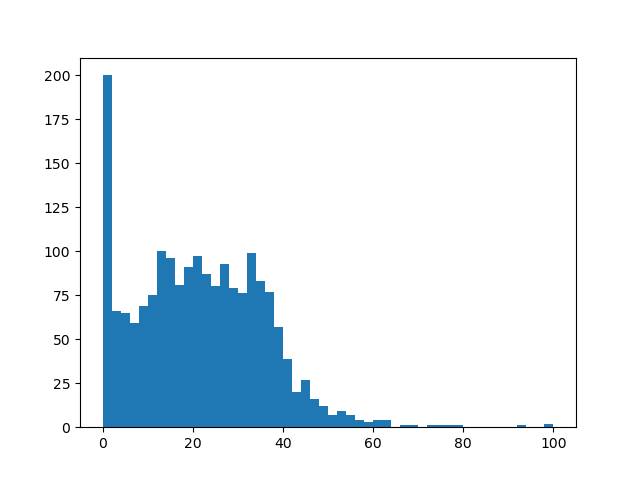

In [37]:
idx_n_hist =[]
idx_v_hist = []

for idx_n, idx_v in core.idx_nv_collect:
    idx_n_hist.append(idx_n)
    idx_v_hist.append(idx_v)


plt.figure()
plt.hist(idx_n_hist,bins=50)
plt.show()

plt.figure()
plt.hist(idx_v_hist,bins=50)
plt.show()

# Density sampling

<IPython.core.display.Javascript object>


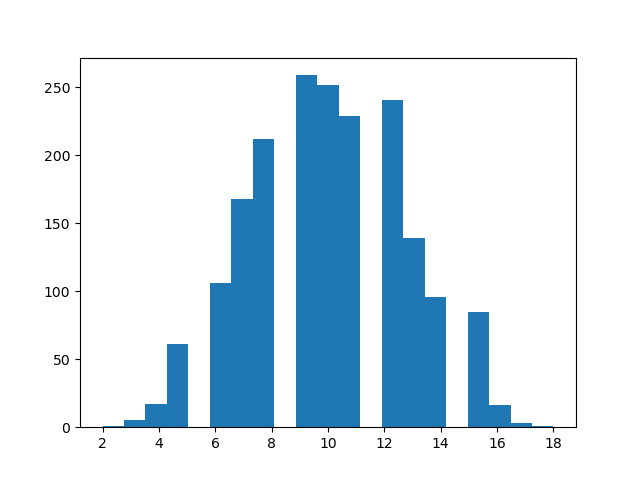

<IPython.core.display.Javascript object>


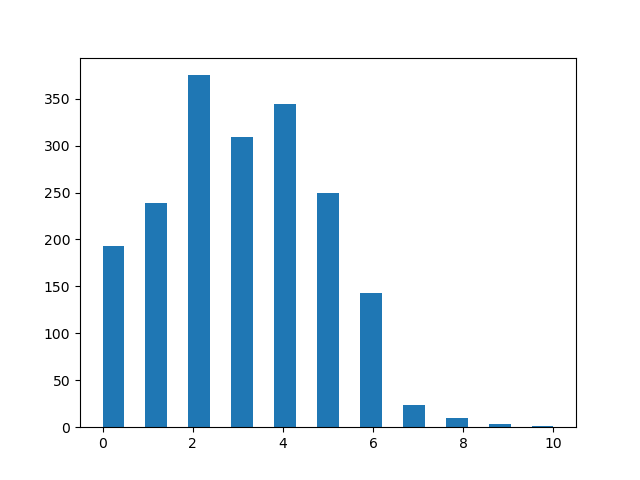

In [36]:
idx_n_hist =[]
idx_v_hist = []

for idx_n, idx_v in core.idx_nv_collect:
    idx_n_hist.append(idx_n)
    idx_v_hist.append(idx_v)


plt.figure()
plt.hist(idx_n_hist,bins=21)
plt.show()

plt.figure()
plt.hist(idx_v_hist,bins=21)
plt.show()

<IPython.core.display.Javascript object>


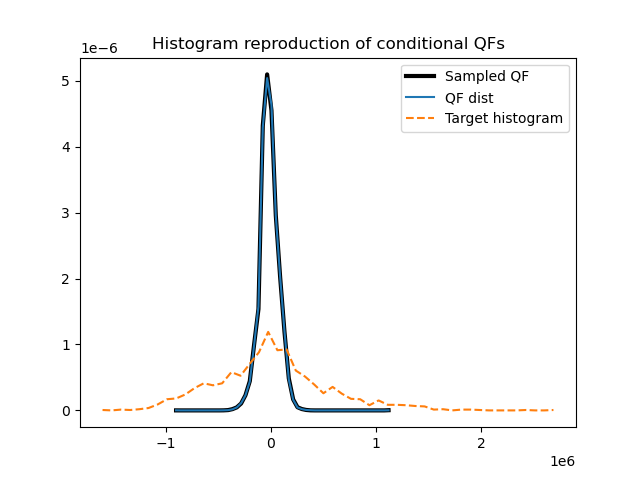

<IPython.core.display.Javascript object>


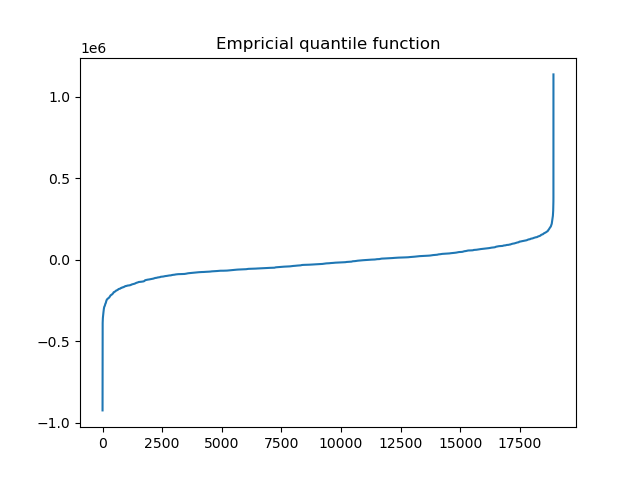

In [52]:
#test_CQF_dist = core.CQF_dist[250,50,:]
#test_CQF_dist = core.CQF_dist[450,50,:]
#test_CQF_dist = core.CQF_dist[50,50,:]
#test_CQF_dist = core.CQF_dist[220,20,:]
test_CQF_dist = core.CQF_dist[10,2,:]

sample_emp_QF = test_CQF_dist[np.random.randint(0,core.condtab_normsize,size=100000)]

hist_bins = 50

plt.figure()

y,binEdges=np.histogram(sample_emp_QF,bins=hist_bins, density = True)
bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
plt.plot(bincenters,y,'-',color = "k", label='Sampled QF', linewidth = 3)  

y,binEdges=np.histogram(test_CQF_dist,bins=hist_bins, density = True)
bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
plt.plot(bincenters,y,'-',color = "C0", label='QF dist')  

y,binEdges=np.histogram(core.data,bins=hist_bins, density = True)
bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
plt.plot(bincenters,y,'--',color = "C1", label='Target histogram')  

plt.title("Histogram reproduction of conditional QFs")
plt.legend()
plt.show()

plt.figure()
plt.plot(test_CQF_dist)
plt.title("Empricial quantile function")
plt.show()

# Count sampling

<IPython.core.display.Javascript object>


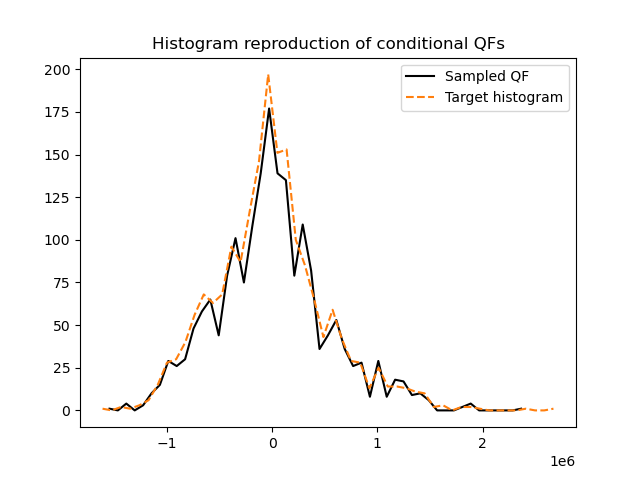

In [22]:
test_CQF_dist = core.CQF_dist[250,50,:]
#test_CQF_dist = core.CQF_dist[450,50,:]
#test_CQF_dist = core.CQF_dist[50,50,:]

sample_emp_QF = test_CQF_dist[np.random.randint(0,core.condtab_normsize,size=len(core.data))]

hist_bins = 50

plt.figure()

y,binEdges=np.histogram(sample_emp_QF,bins=hist_bins, density = False)
bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
plt.plot(bincenters,y,'-',color = "k", label='Sampled QF')  

#y,binEdges=np.histogram(test_CQF_dist,bins=hist_bins, density = True)
#bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
#plt.plot(bincenters,y,'-',color = "C0", label='QF dist')  

y,binEdges=np.histogram(core.data,bins=hist_bins, density = False)
bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
plt.plot(bincenters,y,'--',color = "C1", label='Target histogram')  

plt.title("Histogram reproduction of conditional QFs")
plt.legend()
plt.show()



In [23]:
# animation
from matplotlib import animation, rc
from IPython.display import HTML, Image, display, Video
import os

In [31]:
samples_emp_QF = []
for j in np.arange(0,core.m_DSS.shape[0]):
    nv_in = core.idx_nv_collect[j]
    test_CQF_dist = core.CQF_dist[nv_in[0],nv_in[1],:]
    samples_emp_QF.append(test_CQF_dist[np.random.randint(0,core.condtab_normsize,size=1)])
    
samples_emp_QF = np.array(samples_emp_QF)

In [32]:
samples_emp_QF.shape

(1891, 1)

In [36]:
plt.close("all")

In [1]:
def animate_CQF_sampling(core):

    
    rc('animation', html="jshtml", embed_limit = 10*60)
    #c.embed_limit = 10*10
    
    test_CQF_dist = core.CQF_dist[250,50,:]
    #test_CQF_dist = core.CQF_dist[450,50,:]
    #test_CQF_dist = core.CQF_dist[50,50,:]

    hist_bins = 50

    rgb = 1-(np.arange(0,len(core.data))+1)/len(core.data)

    fig = plt.figure(figsize=(6,6), constrained_layout=False, dpi = 100)

    gs = fig.add_gridspec(1, 1, height_ratios=[1], width_ratios=[1]) # Add x-by-y grid

    ax = fig.add_subplot(gs[0, 0])

    samples_emp_QF = []
    for j in np.arange(0,core.m_DSS.shape[0], step = 1):
        nv_in = core.idx_nv_collect[j]
        test_CQF_dist = core.CQF_dist[nv_in[0],nv_in[1],:]
        #samples_emp_QF.append(test_CQF_dist[np.random.randint(0,core.condtab_normsize,size=len(core.data))])
        samples_emp_QF.append(test_CQF_dist[np.random.randint(0,core.condtab_normsize,size=1)])

    samples_emp_QF = np.array(samples_emp_QF)

    y,binEdges=np.histogram(samples_emp_QF[0,:],bins=hist_bins, density = False)
    bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
    ax.plot(bincenters,y,'-',color = (rgb[0],rgb[0],rgb[0]), zorder = rgb[0], label='Sampled QF')  

    def animate(i):
        y,binEdges=np.histogram(samples_emp_QF[:(i+1),:],bins=hist_bins, density = False)
        bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
        cb = ax.plot(bincenters,y,'-',color = (rgb[i+1],rgb[i+1],rgb[i+1]), zorder = rgb[i+1])
        return (cb,)

    y,binEdges=np.histogram(core.data,bins=hist_bins, density = False)
    bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
    ax.plot(bincenters,y,'--',color = "C1", label='Target histogram', zorder = 10)  

    plt.title("Histogram reproduction of conditional QFs")
    plt.legend()

    anim = animation.FuncAnimation(fig, animate, frames=len(core.data)-1, interval=5)
    #anim = animation.FuncAnimation(fig, animate, frames=600, interval=5)
    
    plt.close() # Close the active figure to avoid extra plot
    
    return anim

animate_CQF_sampling(core)

NameError: name 'core' is not defined

In [24]:
core.rangn[250]

0.0

In [25]:
core.rangv[50]

1.0

In [63]:
def conditional_lookup(self, mu_k, sigma_sq_k, dm, dv, scaling = True):
        #conditional_lookup(self, cond_mean, cond_var, cond_dist, cond_dist_size, mu_k, sigma_sq_k, dm, dv):
        #conditional_lookup(core.CQF_mean, core.CQF_var, core.CQF_dist, core.condtab_normsize, mu_k, sigma_sq_k, dm_c, dv_c)

        #distance = np.power((self.CQF_mean-mu_k)/dm,2)+np.power((self.CQF_var-sigma_sq_k)/dv,2)   
        #distance = np.power((self.CQF_mean-mu_k),2)+np.power((self.CQF_var-sigma_sq_k),2)        
        
        #distance = np.power((self.CQF_mean-mu_k)/dm,2)+abs(self.CQF_var-sigma_sq_k)/np.sqrt(dv)
        distance = abs(self.CQF_mean-mu_k)/dm+abs(self.CQF_var-sigma_sq_k)/dv
        #distance = abs(self.CQF_mean-mu_k)+abs(self.CQF_var-sigma_sq_k)
        #distance = abs(self.CQF_mean-mu_k)+abs(self.CQF_var-sigma_sq_k)
        
        nearest = np.unravel_index(np.argmin(distance),self.CQF_mean.shape)
        idx_n = nearest[0]
        idx_v = nearest[-1]
        
        nearest_dist = self.CQF_dist[idx_n,idx_v,:]
        
        m_i = nearest_dist[np.random.randint(0,self.condtab_normsize,size=1)]

        if scaling == True:
            m_i_mean = self.CQF_mean[idx_n,idx_v]        
            m_i_std = np.sqrt(self.CQF_var[idx_n,idx_v],dtype=np.float64)
            m_k = (m_i - m_i_mean)*np.sqrt(sigma_sq_k)/m_i_std+mu_k
        else:
            m_k = m_i

        return idx_n, idx_v, nearest_dist, m_i, distance

[532]
8
8


<IPython.core.display.Javascript object>


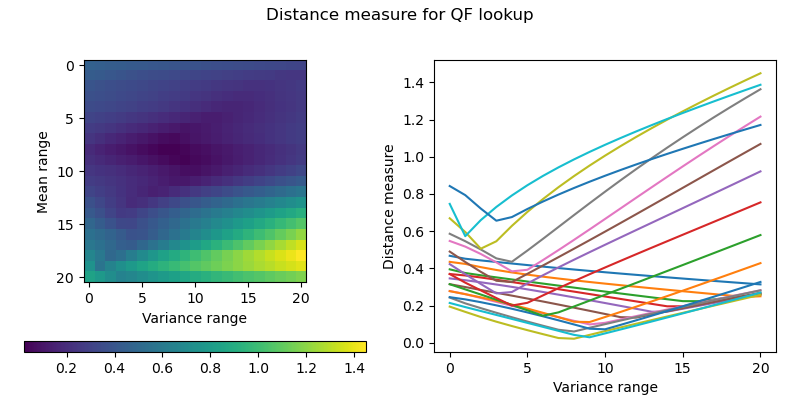

In [65]:
from matplotlib.colorbar import Colorbar

data_min = np.min(core.data)
data_max = np.max(core.data)
dm = data_max - data_min
dv = core.target_var

idx_rand_field_value = np.random.randint(0,len(core.data),size=1)
idx_n, idx_v, nearest_dist, m_i, distance = conditional_lookup(core, core.kriging_mv_collect[int(idx_rand_field_value)][0], 
                                                               core.kriging_mv_collect[int(idx_rand_field_value)][1], dm, dv)
print(idx_rand_field_value)
print(idx_n)
print(idx_v)

fig = plt.figure(figsize=(8,4), constrained_layout=False) # Initiate figure with constrained layout
fig.suptitle("Distance measure for QF lookup")

gs = fig.add_gridspec(2, 2, height_ratios=[1,0.05], width_ratios=[1,1]) # Add x-by-y grid
ax_cb = fig.add_subplot(gs[1, 0])

#% RESIDUALS
ax = fig.add_subplot(gs[0, 0])
im = ax.imshow(distance)
#cbax = plt.subplot(gs[0,0]) # Set colorbar position
cb = Colorbar(mappable = im, ax = ax_cb, orientation = "horizontal") # im, ax=ax, 
ax.set_xlabel("Variance range")
ax.set_ylabel("Mean range")
ax = fig.add_subplot(gs[:, 1])
ax.plot(distance.T)
ax.set_xlabel("Variance range")
ax.set_ylabel("Distance measure")

fig.subplots_adjust(left=0.03, bottom=0.12, right=0.97, top=0.85, wspace = 0.2, hspace=0.5)

plt.show()

In [61]:
core.grid_glq(nmax = 256, r_at = core.r_cmb)
#core.grid_glq(nmax = 120, r_at = core.r_cmb)

core.ensemble_B(core.g_spec, nmax = 30, r_at = core.r_cmb, grid_type = "glq")
zs_eqa = core.B_ensemble_glq[:,0,:].copy()

#core.g_spec_mean = np.mean(core.g_spec,axis=1)
core.ensemble_B(core.g_spec_mean, nmax = 30, r_at = core.r_cmb, grid_type = "glq")
zs_mean_eqa = core.B_ensemble_glq[:,0].copy()

core.ensemble_B(core.g_prior[:mt_util.shc_vec_len(30)], nmax = 30, r_at = core.r_cmb, grid_type = "glq")
prior_eqa = core.B_ensemble_glq[:,0].copy()

core.ensemble_B(core.g_lsq_equiv, nmax = 30, r_at = core.r_cmb, grid_type = "glq")
lsq_eqa = core.B_ensemble_glq[:,0].copy()

<IPython.core.display.Javascript object>


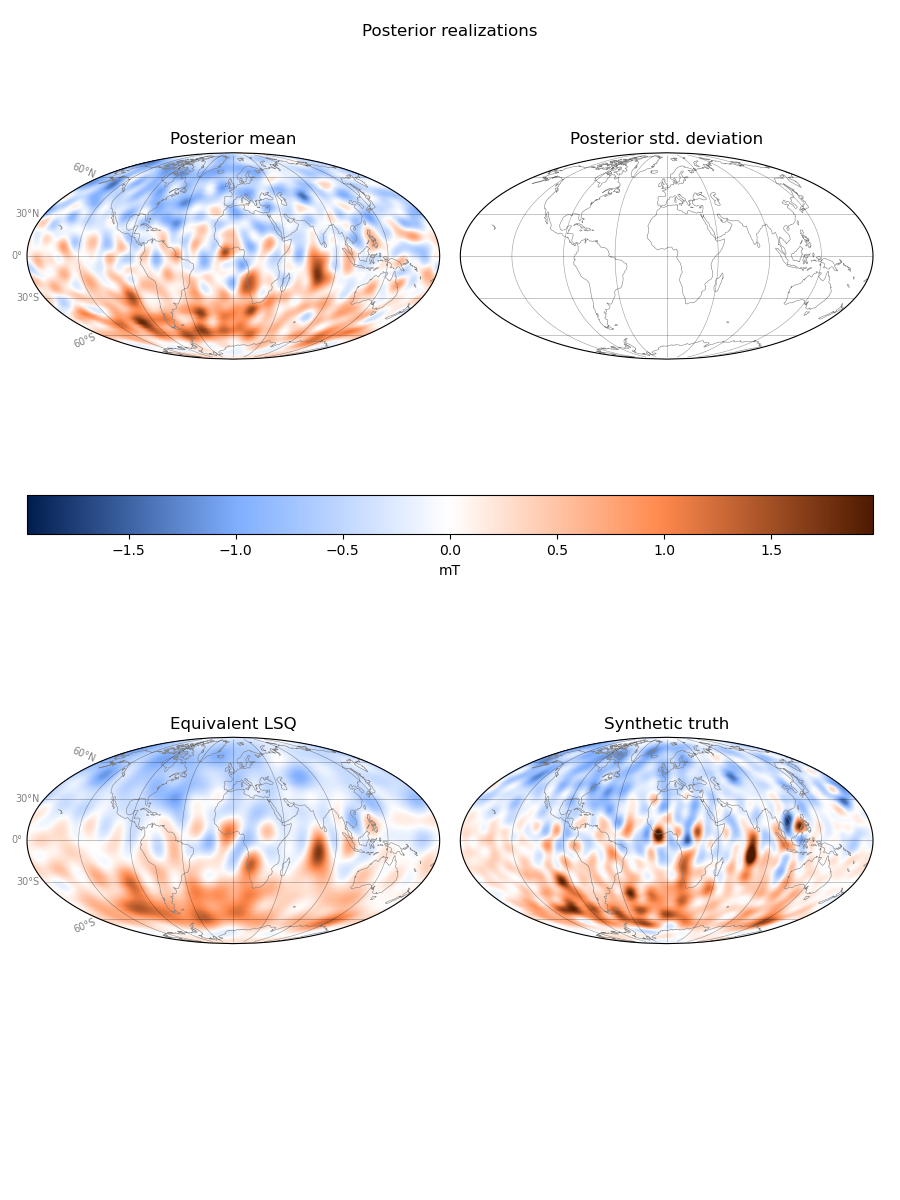

In [62]:
# Reload plot module when making small changes
import importlib
importlib.reload(mt_util)
# ccrs.PlateCarree()
# ccrs.Mollweide()
# ccrs.Orthographic(central_longitude=0.0, central_latitude=0.0)

mt_util.plot_ensemble_map_tiles(core.grid_glq_phi, 90-core.grid_glq_theta, zs_eqa, 
                        field_compare = prior_eqa, field_lsq = lsq_eqa, field_mean = zs_mean_eqa,
                        tile_size_row = 1, tile_size_column = 2, 
                        figsize=(9,12), limit_for_SF = 10**6, point_size = 10, cbar_mm_factor = 2/3,
                        coast_width = 0.4, coast_color = "grey", unit_transform_n_to_m = True,
                        cbar_h = 0.1, cbar_text = "mT", cbar_text_color = "black",
                        left=0.03, bottom=0.12, right=0.97, top=0.95, wspace = 0.05, hspace=0.2, 
                        savefig = False, save_string = "core_A_sh30_pdfhist", 
                        projection = ccrs.Mollweide(), use_gridlines = True, 
                        gridlines_width = 0.4, gridlines_alpha = 0.4, save_dpi = 100)


In [23]:
# SAVE RESULT
#print("\nSaving job")
#file_clip = open("core_{}.obj".format(nb_name), "wb")
#pickle.dump(core, file_clip, protocol=4)
#file_clip.close()

#file_clip = open("sat_{}.obj".format(nb_name), "wb")
#pickle.dump(s_sat, file_clip, protocol=4)
#file_clip.close()
#print("\nJob saved and finished")

In [ ]:
core.kriging_mv_collect